# Log Analysis: Exploration Notebook

Use this notebook to explore generated CSV/JSON outputs from `src/log_analyzer.py`.

In [1]:
# === Imports ===
import pandas as pd
from pathlib import Path


In [2]:
# === Locate report files ===
reports = Path("../reports")

alerts_files = sorted(reports.glob("*_alerts.csv"))
events_files = sorted(reports.glob("*_events.csv"))

alerts_files, events_files


([PosixPath('../reports/report_20251014_194353_alerts.csv'),
  PosixPath('../reports/report_20251014_195006_alerts.csv')],
 [PosixPath('../reports/report_20251014_194353_events.csv'),
  PosixPath('../reports/report_20251014_195006_events.csv')])

In [3]:
# === Load latest CSVs into DataFrames ===
df_alerts = pd.read_csv(alerts_files[-1]) if alerts_files else pd.DataFrame()
df_events = pd.read_csv(events_files[-1]) if events_files else pd.DataFrame()

df_alerts.head(), df_events.head()


(   count           rule                start  \
 0      4  failed_logins  2025-10-14T12:01:10   
 1      3  failed_logins  2025-10-14T12:01:12   
 2      3         errors  2025-10-14T12:03:45   
 
                                         unique_ips  window_sec  
 0  ['192.0.2.45', '198.51.100.33', '203.0.113.10']         300  
 1                ['198.51.100.33', '203.0.113.10']         300  
 2                                              NaN         300  ,
               ip                          msg                   ts   user
 0     192.0.2.45                          NaN  2025-10-14T12:01:10  admin
 1   203.0.113.10                          NaN  2025-10-14T12:01:12   root
 2   203.0.113.10                          NaN  2025-10-14T12:01:15   root
 3  198.51.100.33                          NaN  2025-10-14T12:03:10  guest
 4            NaN  database connection timeout  2025-10-14T12:03:45    NaN)

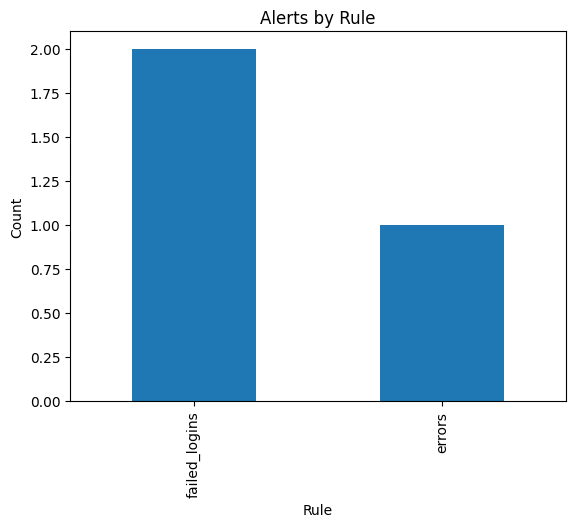

In [4]:
# === Visualize number of alerts by rule type ===
import matplotlib.pyplot as plt

if not df_alerts.empty:
    counts = df_alerts["rule"].value_counts()
    counts.plot(kind="bar")
    plt.title("Alerts by Rule")
    plt.xlabel("Rule")
    plt.ylabel("Count")
    plt.show()
else:
    print("No alerts in latest run.")


In [ ]:
import pandas as pd, matplotlib.pyplot as plt
if not df_alerts.empty:
    ts = pd.to_datetime(df_alerts['start'])
    hourly = ts.dt.floor('H').value_counts().sort_index()
    hourly.plot(kind='line')
    plt.title('Alerts per Hour')
    plt.xlabel('Hour')
    plt.ylabel('Count')
    plt.show()
else:
    print('No alerts to plot by time.')

In [ ]:
if not df_events.empty and 'ip' in df_events.columns:
    top = df_events['ip'].value_counts().head(10)
    top.plot(kind='bar')
    plt.title('Top IPs in Events')
    plt.xlabel('IP')
    plt.ylabel('Count')
    plt.show()
else:
    print('No IP data available in events.')
